# We make up a toy problem to gain intuition about attenion heads

Let's use the following list of words (and a special token):
<Start>, the, man, chicken, ordered,woman, beef    7 words,so V=7, and token ids are 1 to 7

This our corpus:  

<Start> man ordered the chicken

<Start> woman ordered the beef

The corpus will be translated to 2 sequences of token ids as input.

Exercise Instructions:
Let's examine the Attention Wt matrix and Output predictions (see end of notebook) to see how dependencies might be encoded  

Step 1:
Run the notebook, look at how attention matrix might be coding the dependencies.  Recall the attention matrix are like weights because it is multiplied by the Value matrix in the scaled-dot product calculation

Step 2:
Try different values of H parameter (20 works well I think, but not always).

Try 10, 20, 40. Try at least a few runs,
  
for H larger/smaller than 20 is noticably better or worse?
(look at the predictions for token 'the' to see if it predicts 'chicken' or 'beef' appropriately)


In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=4)

import tensorflow as tf

#tf.keras.utils.set_random_seed(777)

#set the embedding/attention head size parameters
E = 7  #size of embedding layer
H = 20  #size of attention head    #<<<<<<<<<---- try 10,20,40 ---
                                     # How does H parameter affect the Attent. Wts?  hint: look at model summary output


2024-06-25 16:59:41.871230: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-25 16:59:41.871288: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-25 16:59:41.872077: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-25 16:59:41.877798: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Set up sequence input


In [2]:
# Set up sequence input
if 1:
    colnames  =  ["<ST>", "the", "man","chkn","ordrd","woman","beef"]
    V    = len(colnames)
    #------ make a sequence of length T --------------
    sequence2use   = np.asarray([[1,3,5,2,4],[1,6,5,2,7]])  #start is first token, with array index 0, 
    B,T            = sequence2use.shape
    sequence2pred  = np.zeros((B,T),dtype=int)
    for bi in range(B):
      sequence2pred[bi,0:-1] = sequence2use[bi,1:]
      sequence2pred[bi,-1]   = sequence2use[bi,0]

#set up a dataframe info for nice printouts later
rownamesxb =list(list())
for bi in range(B):
    rownames=list()
    for i in range(T):
        rownames.append(str(i)+' '+colnames[sequence2use[bi,i]-1])
    rownamesxb.append(rownames)

print('--- Input Sequences (start at 1..T): -----')
print(sequence2use)
print('--- Target Sequences: -----')
print(sequence2pred)


--- Input Sequences (start at 1..T): -----
[[1 3 5 2 4]
 [1 6 5 2 7]]
--- Target Sequences: -----
[[3 5 2 4 1]
 [6 5 2 7 1]]


## Now set up training data (X input and Y targets, and also positions)  
 training data are sequences of token id numbers, but start at 0 to get indexing right
 

In [3]:
#Now set up training data  Batch size is just 1  
#set up token sequences of id numbers  

#Xtrain converts input sequence of ids (but start at 0 )
Xtrain  = np.zeros((B,T,1)) #sequence2use.copy()
for bi in range(B):
    for ti in range(T):
       Xtrain[bi,ti]=sequence2use[bi,ti]-1  #Xtrain_ids[bi,ti]-1  #index starts at 0 so subtract1

#make position information same size as X train 
Postrain=np.zeros((B,T,1))
for bi in range(B):
  Postrain[bi,:,0] = np.arange(T)  #set Position to integer 1...T
#Postrain  = tf.expand_dims(Postrain,axis=2)     #add batch dim to input
print(Postrain.shape)

# make target values as the index 
Ytrain=sequence2pred.copy()
for bi in range(B):
   for ti in range(T):
      Ytrain[bi,ti]=Ytrain[bi,ti]-1  #index starts at 0 so subtract1
Ytrain = tf.expand_dims(Ytrain,axis=2)
print(Ytrain.shape)


(2, 5, 1)
(2, 5, 1)


2024-06-25 16:59:43.496962: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


## Now set up scaled-dot product constants and attention mask

In [4]:
#Now set up model related values
scale_value    = np.divide(1,np.sqrt(H)) #use H b/c it's dimension of Qmat, Kmat
scale_constant =tf.constant(scale_value,dtype=tf.float32)  #this will scale Attn Wts before softmax

#make TxT matrix of scale to apply elememnt wise  
initializer = tf.keras.initializers.Constant(scale_value)
scale_matrix = initializer(shape=(T,T))

#Make a mask
Msk=np.ones((T,T))
Msk = tf.convert_to_tensor(np.tril(Msk))

print('scaling setup')

scaling setup


## Now build model layers that will learn transformation for Q,K,V matrices

In [5]:
#Now build model to learn transformation for Q,K,V matrices

Xseqids_in       = tf.keras.layers.Input(shape=(T),name='Xseqids')        #this takes in the token ids and makes TxV input
Xembed         = tf.keras.layers.Embedding(V,V,input_length=T,name='XEmbed')(Xseqids_in) #1st V is numbr of possible ids, 2nd V is embedding dimension (columns), T is rows

#Xsequence     = tf.keras.layers.Input(shape=(T,V)) #the batch size is left unspecified
Pos_Input     = tf.keras.layers.Input(shape=(T),name='PosInput') #just the t=1...T integer
Pos_Embed     = tf.keras.layers.Embedding(T,V, input_length=T,name='PosEmbed')(Pos_Input) #input will be a number between 1 and T for length=T times
Xinputs       = tf.keras.layers.Add(name='XwithPos')([Xembed, Pos_Embed])

#now feed to Q,K,V transformations
Qmat       = tf.keras.layers.Dense(H,activation='linear',use_bias=False,name='Qmat')(Xinputs) #so for BxTxV input this should be T*V to H dense?
Kmat       = tf.keras.layers.Dense(H,activation='linear',use_bias=False,name='Kmat')(Xinputs) 
Vmat       = tf.keras.layers.Dense(V,activation='linear',use_bias=False,name='Vmat')(Xinputs) #Vmat output is V columns to use it as output

#now apply QtoK take softmax, scale it , apply to V
QK          = tf.keras.layers.Dot(axes=(2))([Qmat,Kmat])  #it will treat each Batch item separately
QKscaled    = tf.keras.layers.Lambda(lambda x: x * scale_constant)(QK)    #for each x in QK mult by scale
Attn_Wts     = tf.keras.layers.Softmax(axis=2,name='AttnWts')(QKscaled, mask=Msk)        #apply mask, apply softmax across row elemnts

Vout       = tf.keras.layers.Dot(axes=(2,1),name='Voutput')([Attn_Wts,Vmat])     #turn this off for our tests, and ..

#add this Add layer, with Xinputs skipped ahead to this input
VoutandXinput = tf.keras.layers.Add(name='skipadd')([Vout,Xinputs])  #<<< this is a skip connection with plus (aka residual skip connection)

Pout  = tf.keras.layers.Activation(activation='sigmoid')(VoutandXinput)

my_attn_model   = tf.keras.Model(inputs = [Xseqids_in,Pos_Input], outputs=Pout)

my_attn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Xseqids (InputLayer)        [(None, 5)]                  0         []                            
                                                                                                  
 PosInput (InputLayer)       [(None, 5)]                  0         []                            
                                                                                                  
 XEmbed (Embedding)          (None, 5, 7)                 49        ['Xseqids[0][0]']             
                                                                                                  
 PosEmbed (Embedding)        (None, 5, 7)                 35        ['PosInput[0][0]']            
                                                                                              

## 'compile' model

In [6]:
#configure loss and optimizer  

#my_attn_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01), 
my_attn_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), 
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)) #logits=T means it is a linear output -inf to +inf

#Note: Sparse loss means Keras expect target to be an integer indicating which output should be 'on'


In [7]:
#Note, if the loss is still going down, you can just keep running this cell to 
#  continue training

red_lrate = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,min_lr=0.0001, patience=10,verbose=1)

#split up training so we can have verbose comments for beginning and end
my_attn_model.fit( [Xtrain,Postrain],Ytrain,batch_size=2,shuffle=True,epochs=10,verbose=2)
my_attn_model.fit( [Xtrain,Postrain],Ytrain,batch_size=2,shuffle=True,epochs=5000,verbose=0,callbacks=[red_lrate])
my_attn_model.fit( [Xtrain,Postrain],Ytrain,batch_size=2,shuffle=True,epochs=10,verbose=2)



Epoch 1/10
1/1 - 0s - loss: 1.9466 - 314ms/epoch - 314ms/step
Epoch 2/10
1/1 - 0s - loss: 1.9430 - 2ms/epoch - 2ms/step
Epoch 3/10
1/1 - 0s - loss: 1.9393 - 1ms/epoch - 1ms/step
Epoch 4/10
1/1 - 0s - loss: 1.9356 - 1ms/epoch - 1ms/step
Epoch 5/10
1/1 - 0s - loss: 1.9320 - 1ms/epoch - 1ms/step
Epoch 6/10
1/1 - 0s - loss: 1.9283 - 1ms/epoch - 1ms/step
Epoch 7/10
1/1 - 0s - loss: 1.9247 - 1ms/epoch - 1ms/step
Epoch 8/10
1/1 - 0s - loss: 1.9211 - 1ms/epoch - 1ms/step
Epoch 9/10
1/1 - 0s - loss: 1.9175 - 1ms/epoch - 1ms/step
Epoch 10/10
1/1 - 0s - loss: 1.9139 - 1ms/epoch - 1ms/step

Epoch 4614: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.

Epoch 4625: ReduceLROnPlateau reducing learning rate to 0.0003999999724328518.

Epoch 4635: ReduceLROnPlateau reducing learning rate to 0.0001.
Epoch 1/10
1/1 - 0s - loss: 0.1619 - 3ms/epoch - 3ms/step
Epoch 2/10
1/1 - 0s - loss: 0.1619 - 1ms/epoch - 1ms/step
Epoch 3/10
1/1 - 0s - loss: 0.1619 - 1ms/epoch - 1ms/step
Epoch 4/10
1/1 -

## Now we want to examine the Attention Wt matrix see how those matrices affect 'the' predictions for each input sequence

First, just gather layer outputs


In [8]:
#get layer outputs (like we did with MNIST), to use below
layer_outputs     = [layer.output for layer in my_attn_model.layers[:]]
my_model_actvtns  = tf.keras.models.Model(inputs=my_attn_model.input, outputs=layer_outputs)
my_actvtns_output = my_model_actvtns.predict([Xtrain,Postrain]) 
#my_actvtns_output = my_model_actvtns.predict(Xtrain) 

print('There are ',str(len(my_actvtns_output))+ ' layers with output activations')


1/1 [==============================] - 0s 117ms/step
There are  14 layers with output activations


In [9]:
#Print layer names and count layers
layercnt=0
for layer in my_attn_model.layers[:]:
    print('layer num',layercnt,layer.name)
    layercnt+=1


layer num 0 Xseqids
layer num 1 PosInput
layer num 2 XEmbed
layer num 3 PosEmbed
layer num 4 XwithPos
layer num 5 Qmat
layer num 6 Kmat
layer num 7 dot
layer num 8 lambda
layer num 9 AttnWts
layer num 10 Vmat
layer num 11 Voutput
layer num 12 skipadd
layer num 13 activation


In [10]:
# Helper functions to plot heat map
import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    if ax is None:
        ax = plt.gca()
    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    #cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    #cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im #, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

---  Note, the head size H was:  20
 ----------- Attention Wts TxT --------------


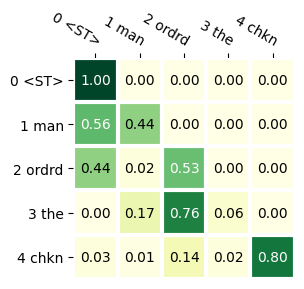

 ----------- Attention Wts TxT --------------


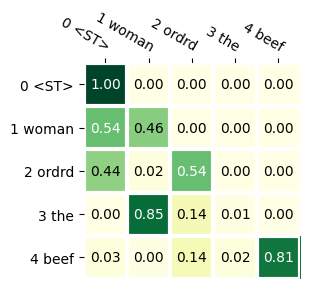

In [11]:
#  <<<<<<< ------------ Can you inteprety how Attn Wts are picking out predictions  
layernum2get=9
AttnW_output = my_actvtns_output[layernum2get]

print('---  Note, the head size H was: ',H)
for bi in [0,1]:  #bi=0  plt.figure(figsize=(10,6)
  print(' ----------- Attention Wts TxT --------------')
  fig, ax = plt.subplots(figsize=(5,3))
  im = heatmap(AttnW_output[bi],rownamesxb[bi], rownamesxb[bi],ax=ax,cmap="YlGn", cbarlabel="attn wt")
  #im, cbar = heatmap(AttnW_output[bi],rownamesxb[bi], rownamesxb[bi],ax=ax,cmap="YlGn", cbarlabel="attn wt")
  texts = annotate_heatmap(im, valfmt="{x:.2f}")
  fig.tight_layout()
  plt.show()


1/1 [==============================] - 0s 86ms/step
 ---------- Output Predictions TxV (t-th row are predictions at time t) --


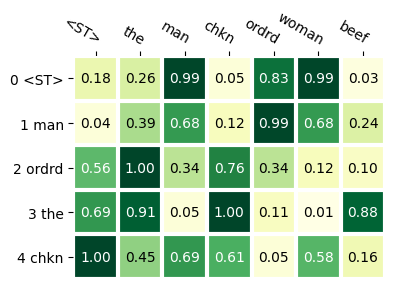

 ---------- Output Predictions TxV (t-th row are predictions at time t) --


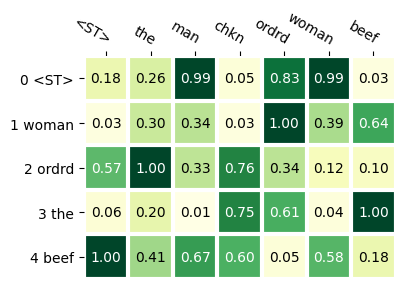

In [12]:
Vout_pred =my_attn_model.predict([Xtrain,Postrain])

for bi in range(B):
  print(' ---------- Output Predictions TxV (t-th row are predictions at time t) --')
  fig, ax = plt.subplots(figsize=(5,3))
  im = heatmap(Vout_pred[bi],rownamesxb[bi], colnames,ax=ax,cmap="YlGn")
  texts = annotate_heatmap(im, valfmt="{x:.2f}")
  fig.tight_layout()
  plt.show()
